In [69]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25


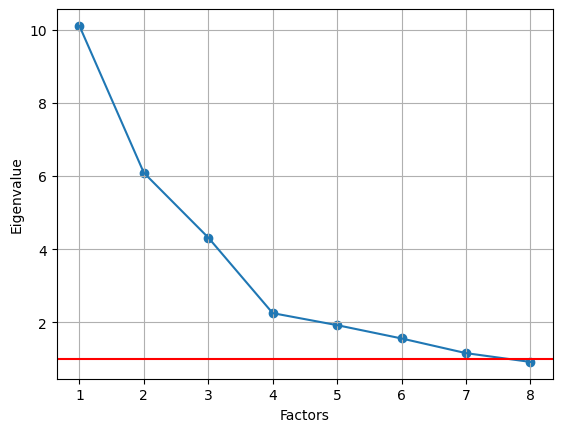

In [2]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [3]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6239602297891018

In [4]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 11030.040954824713, p-value: 0.0


In [5]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
f_freedom,-0.362566,0.017590,-0.168421,-0.730520,0.125812,-0.195287,0.128615
distance_between_atoms_in_cycle_and_f_group,0.926541,0.008531,0.176059,0.086969,0.036879,0.049971,0.027155
PPSA5,0.185657,-0.061437,0.142254,0.240290,-0.400971,0.695177,-0.021480
mol_num_cycles,0.084508,0.922421,0.284980,0.046856,-0.029951,-0.130597,0.056740
nFRing,-0.154710,0.787342,0.272866,0.046318,0.168922,0.073312,0.193402
angle_R1X1R2,0.972522,0.018951,0.005267,0.081045,0.069899,0.066673,0.068464
nF,0.535480,-0.154120,0.028334,0.628134,0.063616,0.527672,0.078909
identificator,0.102796,0.099629,0.051991,-0.023787,0.888306,-0.123985,-0.057494
mol_weight,0.415466,0.185595,0.539407,0.406379,-0.274683,0.391292,-0.004118
dipole_moment,0.033252,0.070426,0.045317,0.282339,0.198781,-0.014984,0.132577


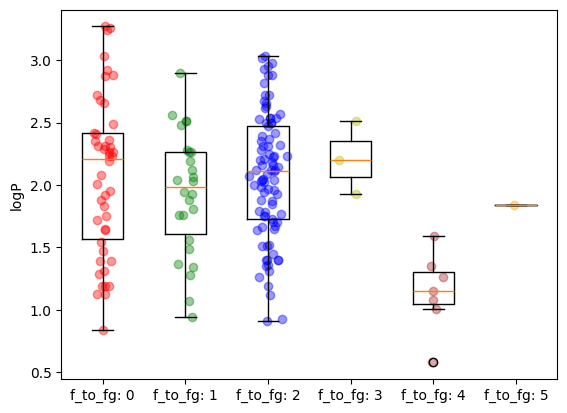

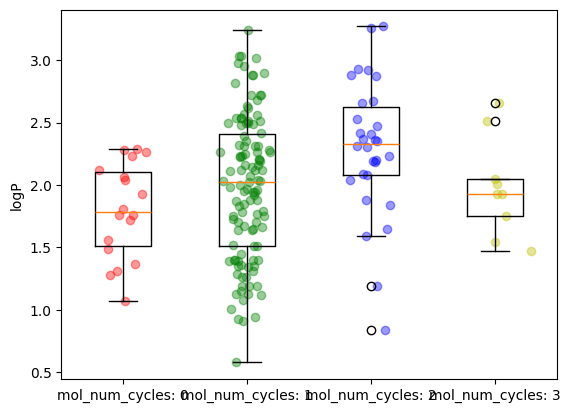

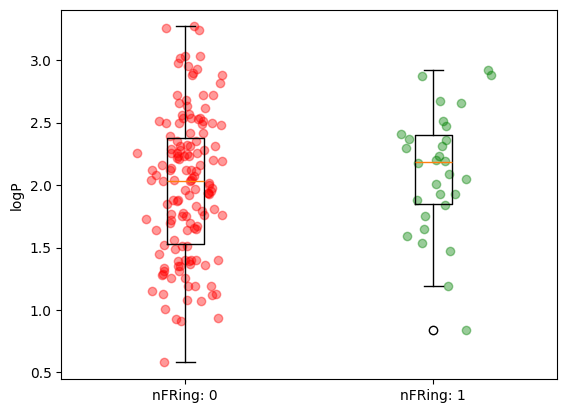

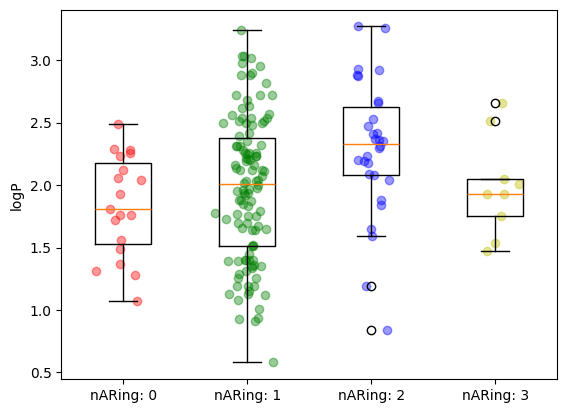

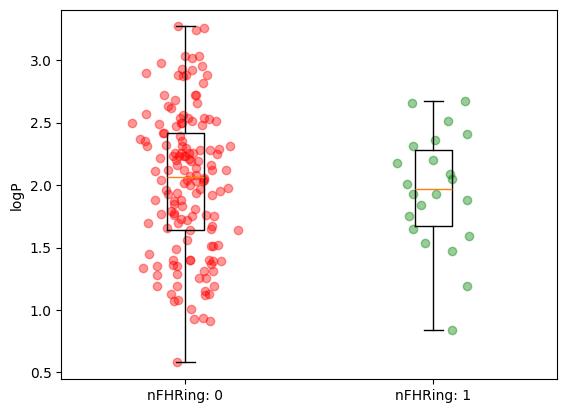

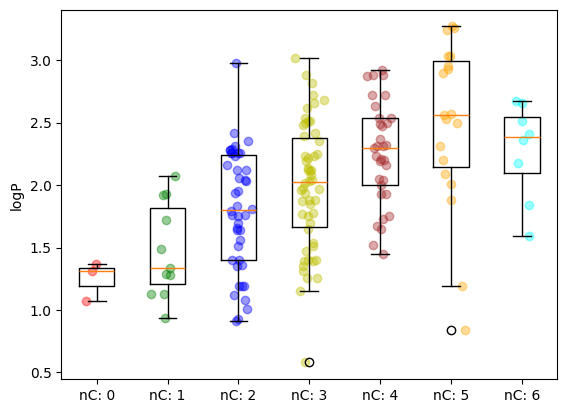

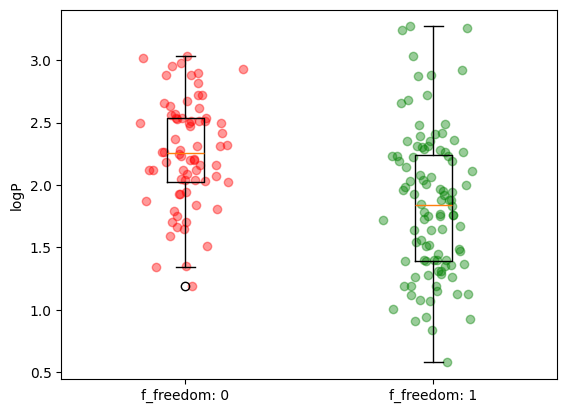

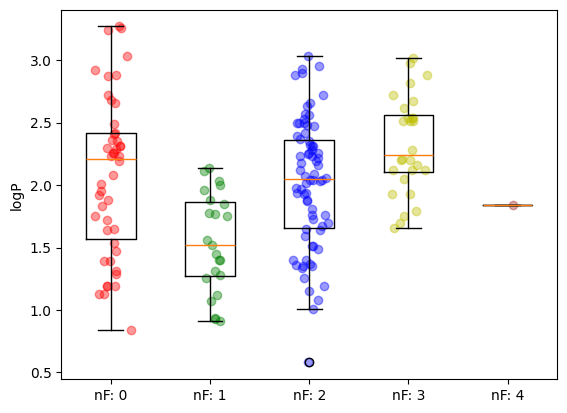

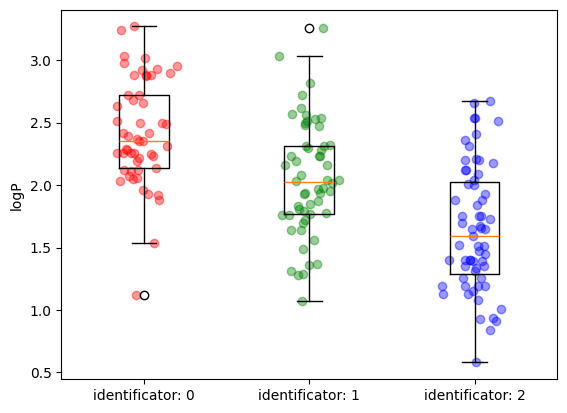

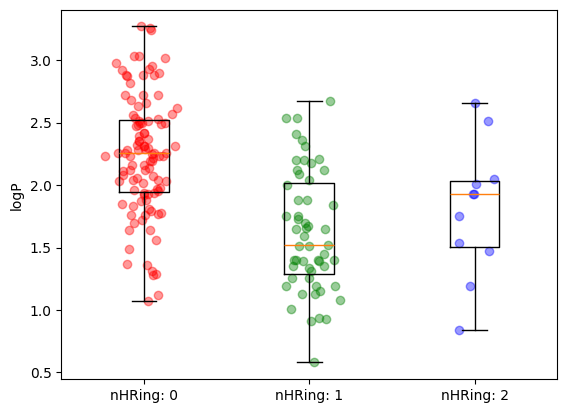

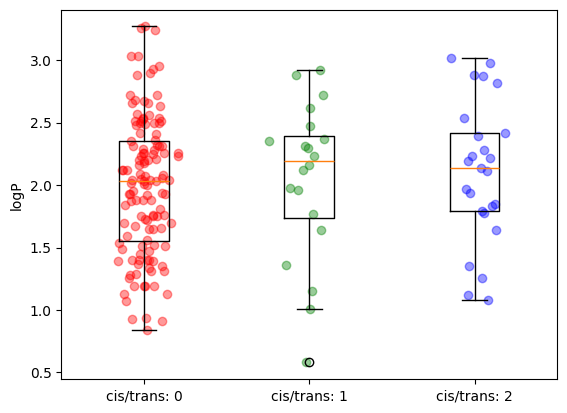

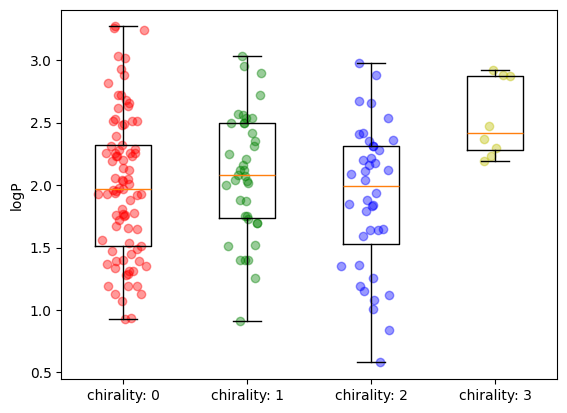

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.6:
            continue

        if feature_names[feature_index] == 'logP':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        # print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            continue
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('logP')
            plt.ylabel(feature_names[feature_index])
            plt.show()

        else:
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['logP']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                xs.append(np.random.normal(i + 1, 0.08, values.shape[0])) 
            
            plt.boxplot(vals, labels=names)
            plt.ylabel('logP')
            palette = ['r', 'g', 'b', 'y', 'brown', 'orange', 'cyan', 'purple', 'olive']
            for x, val, c in zip(xs, vals, palette):
                plt.scatter(x, val, alpha=0.4, color=c)
            plt.show()
            
                


Amount of feature: distance_between_atoms_in_cycle_and_f_group: 103
R^2 score: 0.003020559379629921
{'mse': 0.383, 'mae': 0.508, 'r_score': 0.003}


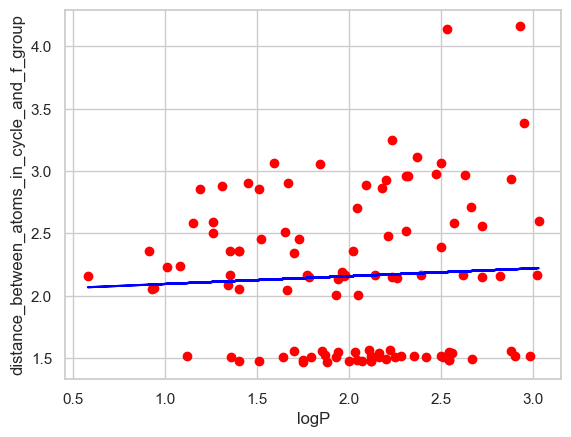

Amount of feature: angle_R1X1R2: 103
R^2 score: 0.11449287791547469
{'mse': 757.224, 'mae': 22.941, 'r_score': 0.114}


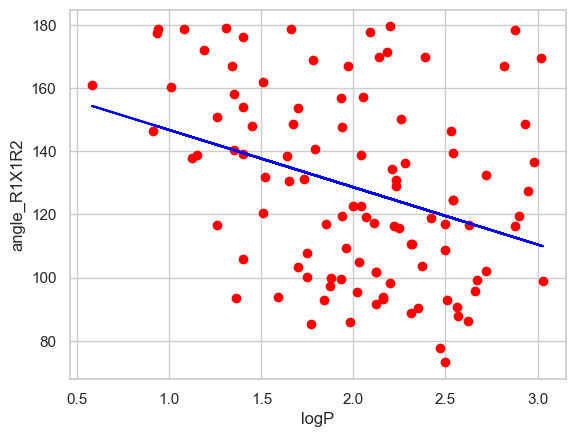

Amount of feature: angle_X2X1R1: 103
R^2 score: 0.25710357026862957
{'mse': 347.731, 'mae': 15.24, 'r_score': 0.257}


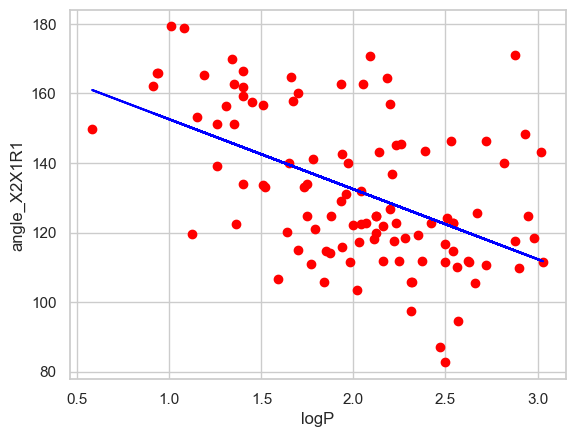

Amount of feature: angle_R2X2R1: 103
R^2 score: 0.005158240369145058
{'mse': 582.272, 'mae': 20.456, 'r_score': 0.005}


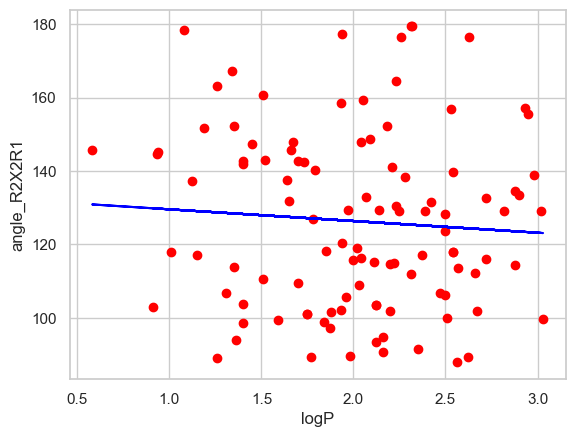

Amount of feature: f_to_fg: 6
Kruskal for f_to_fg: 16.55
P-value: 0.0054
There is a statistically significant difference between the groups


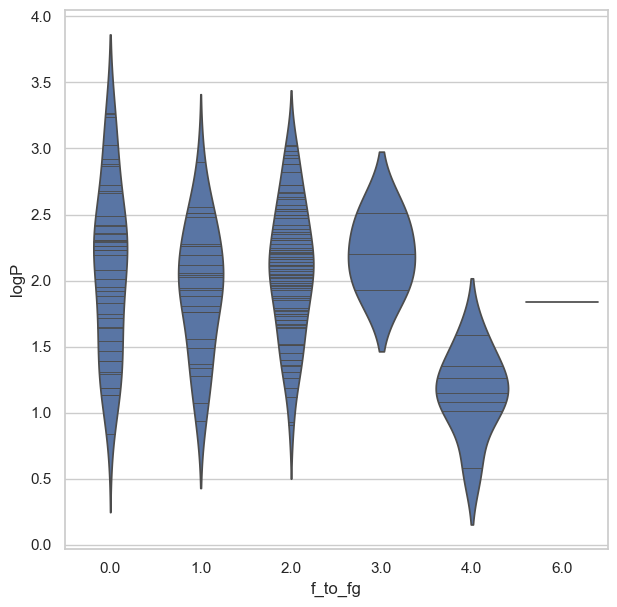

Amount of feature: dihedral_angle: 103
R^2 score: 0.002929289641114709
{'mse': 4525.981, 'mae': 59.8, 'r_score': 0.003}


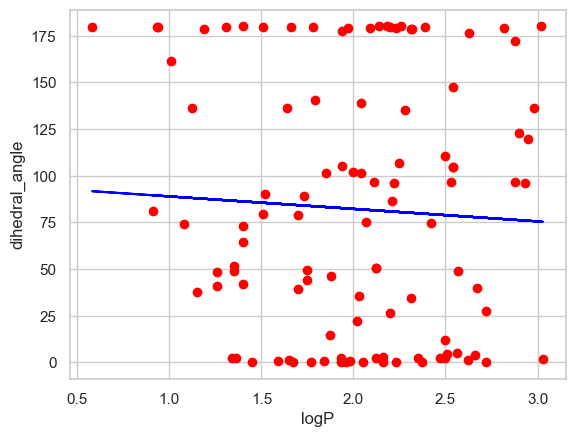

Amount of feature: distance_between_atoms_in_f_group_centers: 103
R^2 score: 0.008509466624910969
{'mse': 0.551, 'mae': 0.618, 'r_score': 0.009}


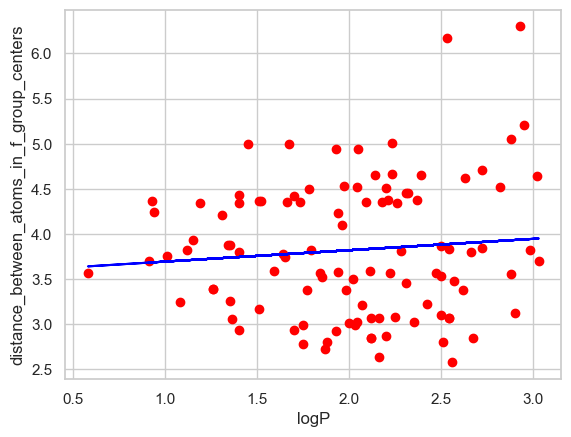

Amount of feature: angle_X1X2R2: 103
R^2 score: 0.001540484445815787
{'mse': 316.259, 'mae': 15.538, 'r_score': 0.002}


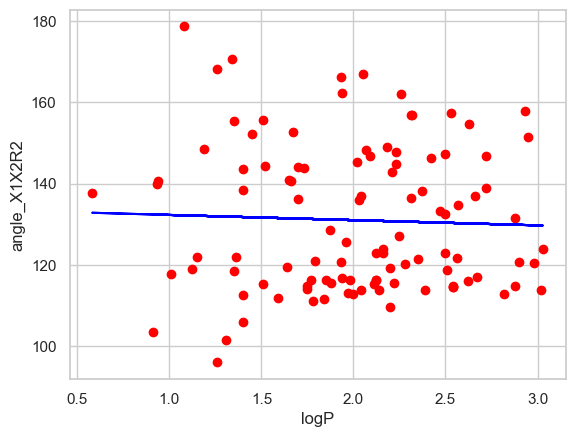

Amount of feature: mol_num_cycles: 4
Kruskal for mol_num_cycles: 11.73
P-value: 0.0084
There is a statistically significant difference between the groups


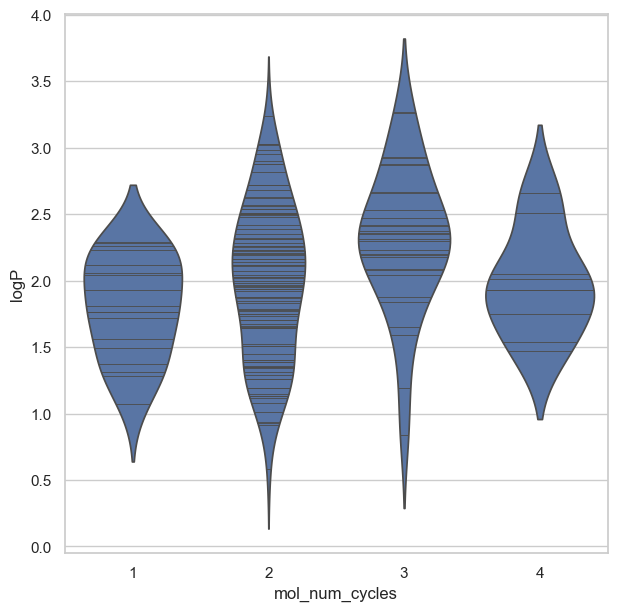

Amount of feature: nFRing: 2
Mann-Whitney U for nFRing: 1866.50
P-value: 0.2885
There isn't any statistically significant difference between the groups


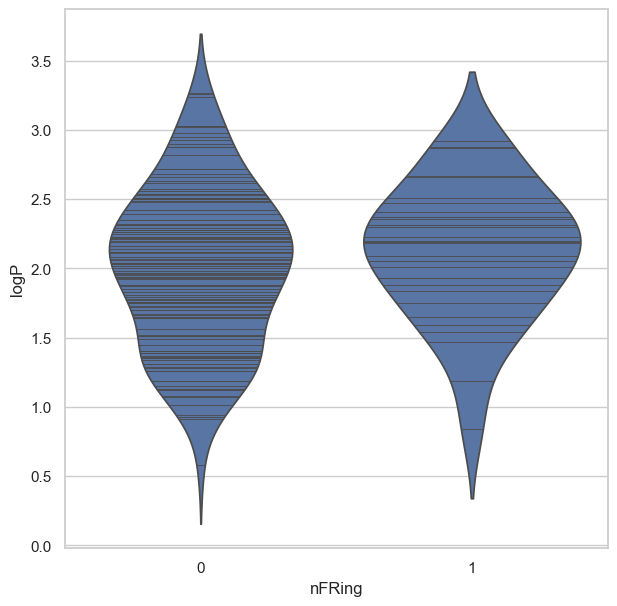

Amount of feature: nARing: 4
Kruskal for nARing: 10.93
P-value: 0.0121
There is a statistically significant difference between the groups


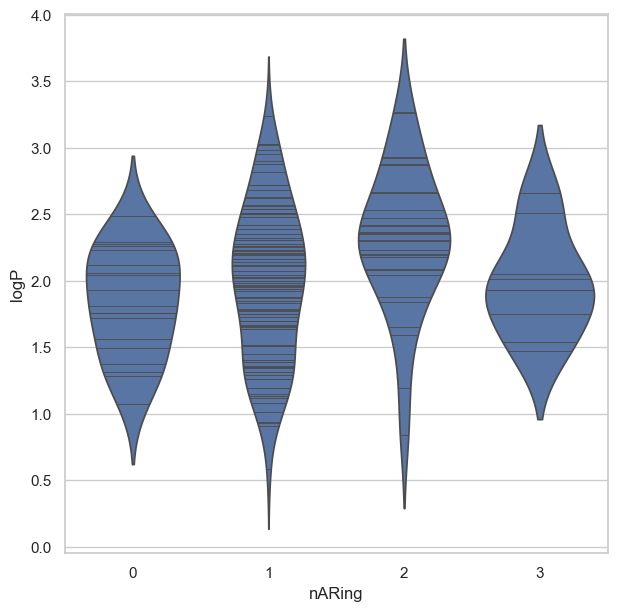

Amount of feature: avg_atoms_in_cycle: 11
R^2 score: 0.008110659365825062
{'mse': 0.705, 'mae': 0.674, 'r_score': 0.008}


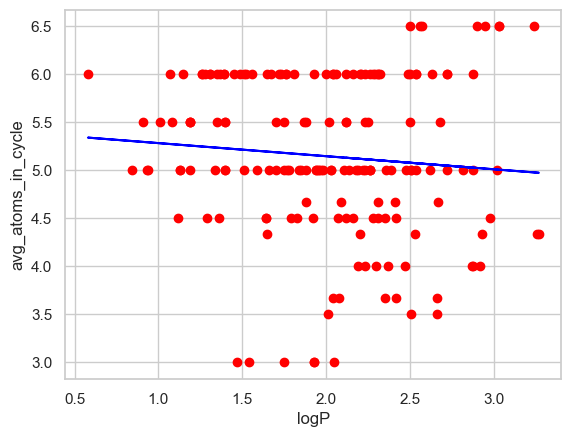

Amount of feature: nFHRing: 2
Mann-Whitney U for nFHRing: 1765.50
P-value: 0.5980
There isn't any statistically significant difference between the groups


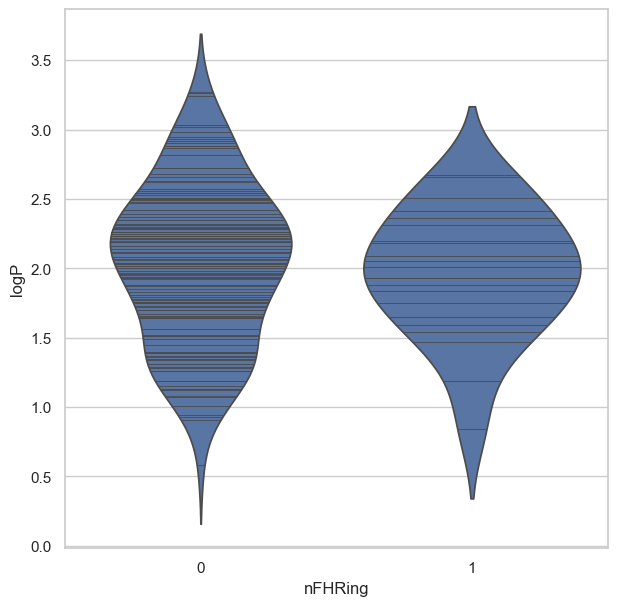

Amount of feature: PBF: 164
R^2 score: 0.20344360468656777
{'mse': 0.018, 'mae': 0.107, 'r_score': 0.203}


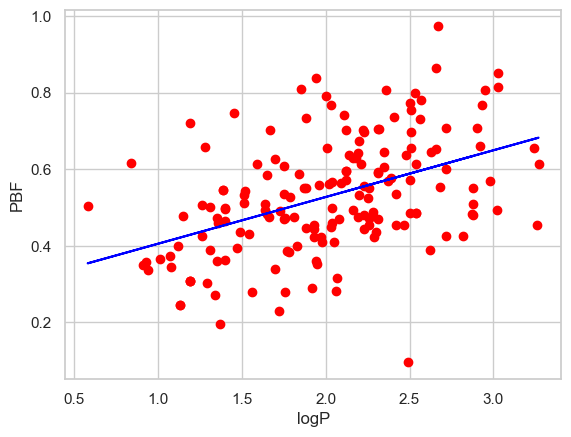

Amount of feature: nC: 7
Kruskal for nC: 44.17
P-value: 0.0000
There is a statistically significant difference between the groups


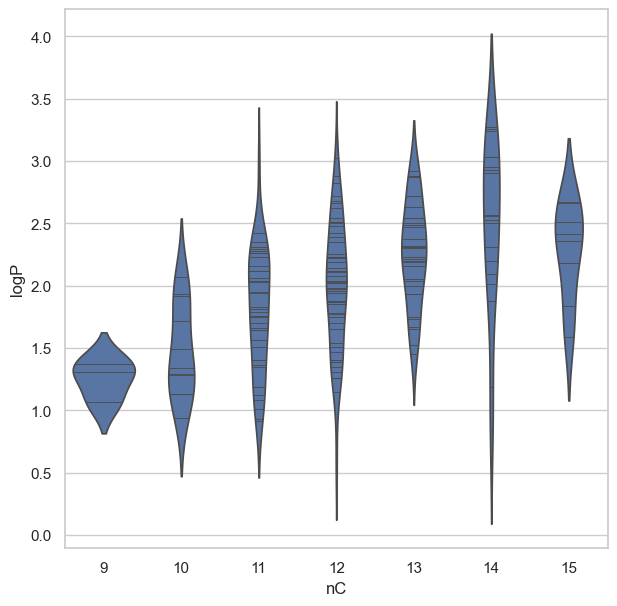

Amount of feature: mol_volume: 163
R^2 score: 0.2536397889641837
{'mse': 275.017, 'mae': 12.69, 'r_score': 0.254}


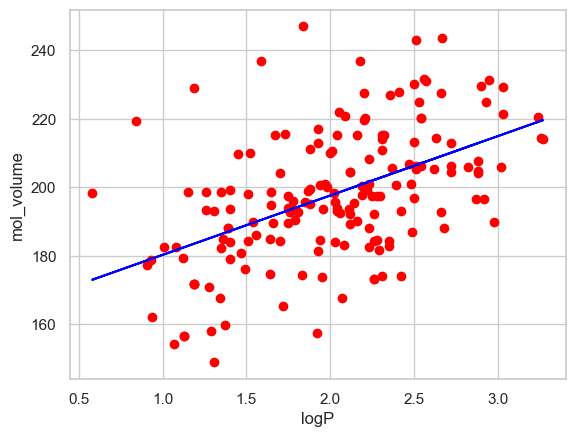

Amount of feature: f_freedom: 2
Mann-Whitney U for f_freedom: 5210.50
P-value: 0.0000
There is a statistically significant difference between the groups


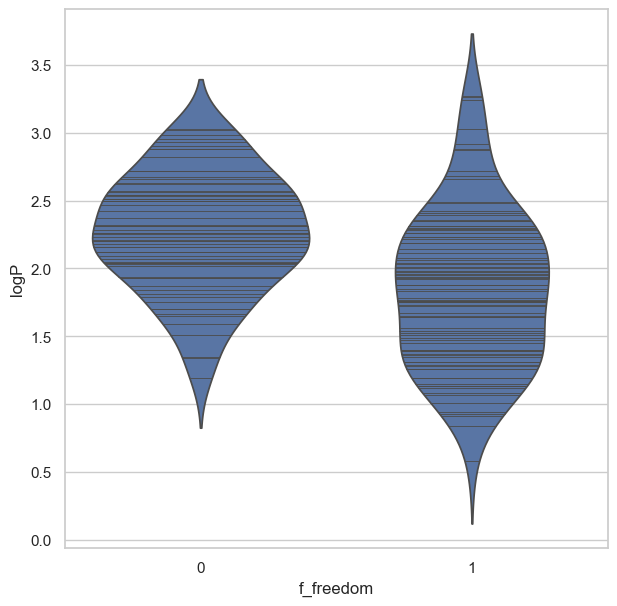

Amount of feature: nF: 5
Kruskal for nF: 26.90
P-value: 0.0000
There is a statistically significant difference between the groups


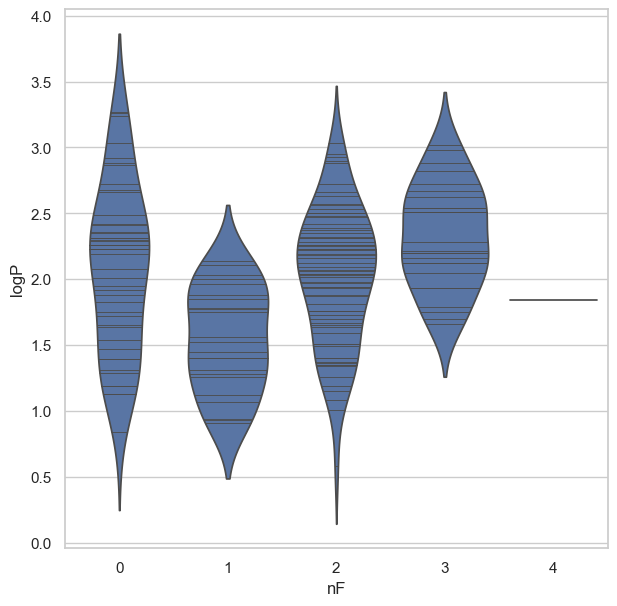

Amount of feature: FPSA3: 164
R^2 score: 0.3316989826136607
{'mse': 0.0, 'mae': 0.002, 'r_score': 0.332}


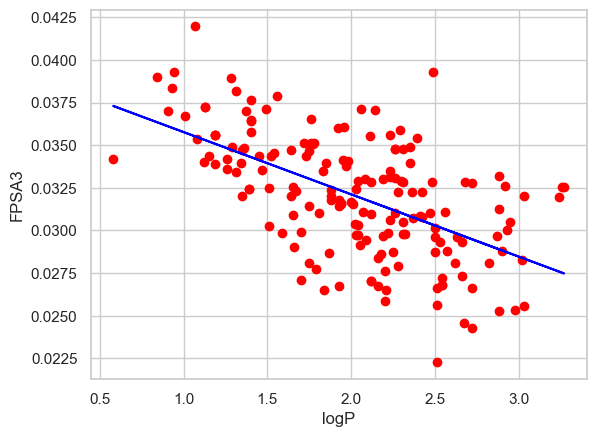

Amount of feature: RPCS: 140
R^2 score: 0.19077290014208123
{'mse': 201.3, 'mae': 12.097, 'r_score': 0.191}


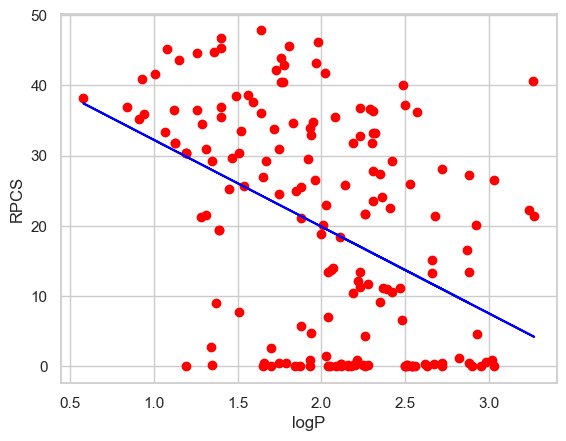

Amount of feature: identificator: 3
Kruskal for identificator: 54.73
P-value: 0.0000
There is a statistically significant difference between the groups


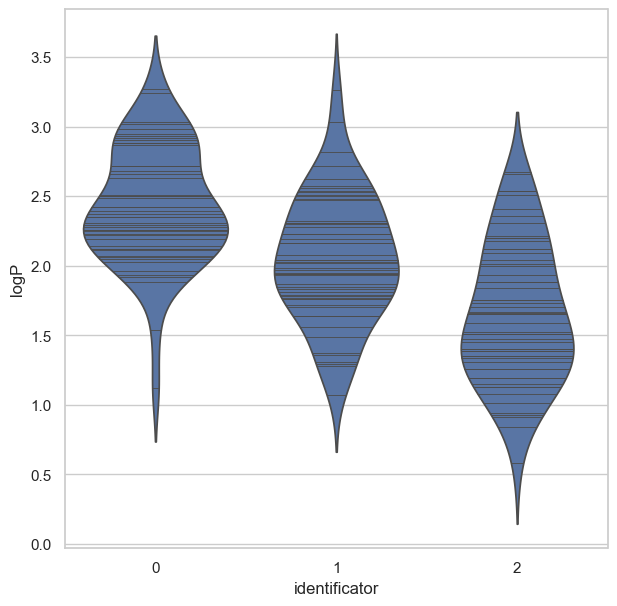

Amount of feature: nHRing: 3
Kruskal for nHRing: 44.29
P-value: 0.0000
There is a statistically significant difference between the groups


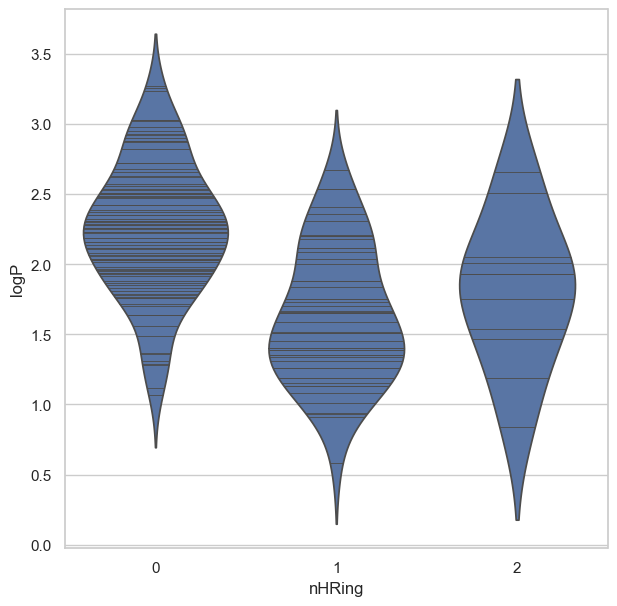

Amount of feature: PPSA5: 164
R^2 score: 0.1367320303073437
{'mse': 1.115, 'mae': 0.863, 'r_score': 0.137}


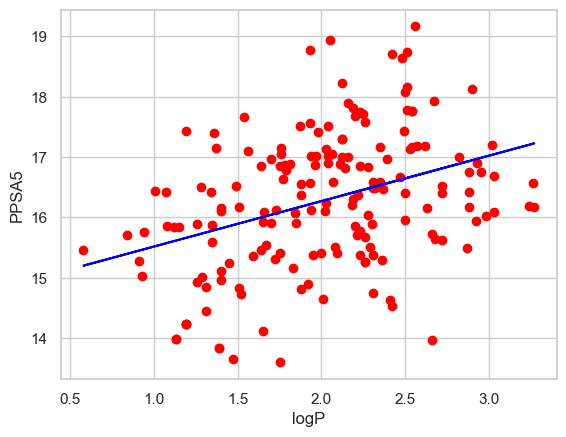

Amount of feature: WPSA5: 164
R^2 score: 0.3103017275281982
{'mse': 0.359, 'mae': 0.482, 'r_score': 0.31}


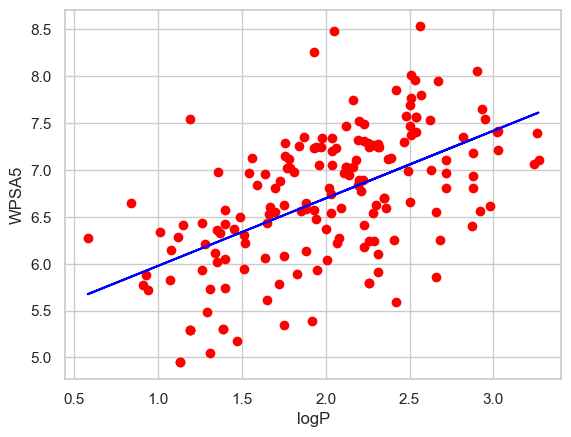

Amount of feature: cis/trans: 3
Kruskal for cis/trans: 1.05
P-value: 0.5904
There isn't any statistically significant difference between the groups


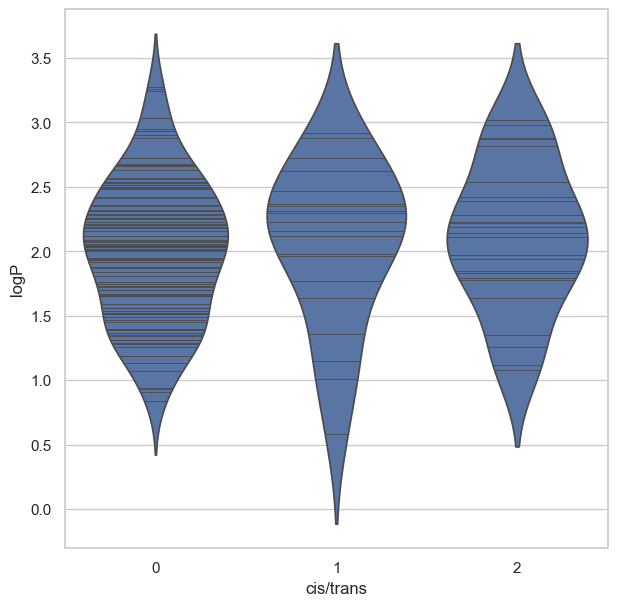

Amount of feature: chirality: 4
Kruskal for chirality: 9.46
P-value: 0.0238
There is a statistically significant difference between the groups


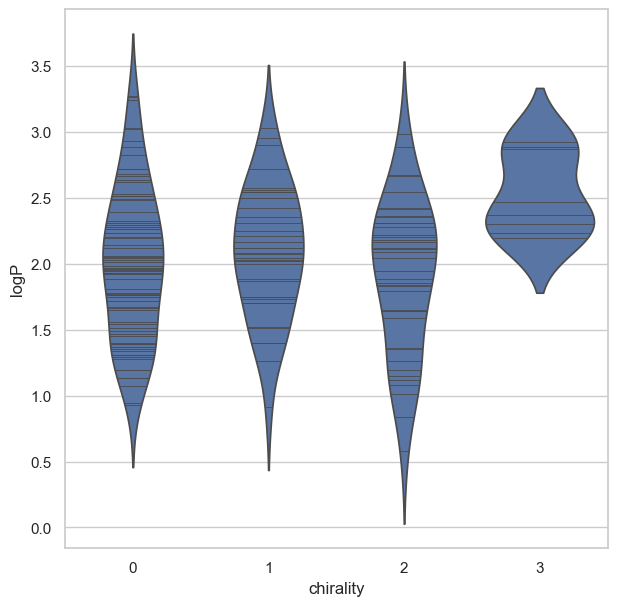

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress, mannwhitneyu, kruskal
import seaborn

seaborn.set_theme(style = 'whitegrid') 


def complete_mannwhitneyu_test(values1, values2, feature_name):
    result = mannwhitneyu(values1, values2, alternative='two-sided')

    print(f"Mann-Whitney U for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


def complete_kruskal_test(groups, feature_name):
    result = kruskal(*groups)

    print(f"Kruskal for {feature_name}: {result.statistic:.2f}")
    print(f"P-value: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print("There is a statistically significant difference between the groups")
    else:
        print("There isn't any statistically significant difference between the groups")


feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.6:
            continue

        if feature_names[feature_index] == 'logP':
            continue
        
        feature_name = feature_names[feature_index]
        # print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])


        print(f"Amount of feature: {feature_name}: {len(set(y))}")
        if len(set(y)) > 10:
            slope, intercept, r, p, se = linregress(x, y)
            y_line = [slope * xi + intercept for xi in x]

            print(f"R^2 score: {pow(r, 2)}")
            print(calculate_metrics(y, y_line))

            plt.scatter(x=x, y=y, color="red")
            plt.plot(x, y_line, color="blue")
            plt.xlabel('logP')
            plt.ylabel(feature_names[feature_index])
            plt.show()
            # break

        else:

            df_dict = {}
            vals, names, xs = [],[],[]
            for i, unique_values in enumerate(sorted(set(y))):
                values = df_features[df_features[feature_name] == unique_values]['logP']
                vals.append(values)
                names.append(f"{feature_name}: {i}")
                df_dict[f"{feature_name}: {unique_values}"] = values
                xs.append(np.random.normal(unique_values, 0.08, values.shape[0])) 

            if len(set(y)) == 2:
                values1 = df_features[df_features[feature_name] == list(set(y))[0]]['logP']
                values2 = df_features[df_features[feature_name] == list(set(y))[1]]['logP']
                complete_mannwhitneyu_test(values1=values1, 
                                           values2=values2, 
                                           feature_name=feature_name)
            else:
                complete_kruskal_test(groups=vals, 
                                      feature_name=feature_name)
            
            df = pd.DataFrame(df_dict)

            plt.figure(figsize=(7,7))
            seaborn.violinplot(x=feature_name, y ='logP',
                               data = df_features,
                               inner="stick")
            plt.show()
            
                
